# Illustration of a particle filter analysis

Our physical system is described by two variables. In the cell below, we form an ensemble of possible realizations of this system, based on prior statistical parameters.

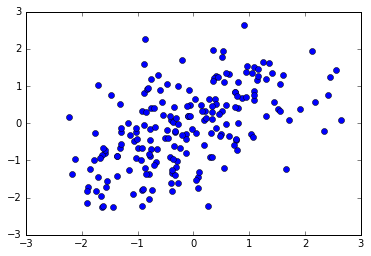

In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mu = np.zeros(2)
pmat = np.array([[1., 0.5], [0.5, 1.]])
Nmem = 200
xxb = np.random.multivariate_normal( mu, pmat, Nmem )
plt.plot(xxb[:,0], xxb[:,1], 'o')

Below we define functions to perform a particle filter analysis.

In [113]:
def likelihood(y_in, yo_in, Ro_in):
    innovation = yo_in - y_in
    invRo = np.linalg.inv(Ro_in)
    xtmp = np.dot(invRo, innovation)
    xtmp = -0.5 * np.dot(innovation, xtmp)
    xtmp = np.exp(xtmp)
    return xtmp

def particle_filter_analysis(xxb_in, Ho_in, yo_in, Ro_in):
    """Perform particle filter analysis"""
    Nm = np.shape(xxb_in)[0]
    
    ## Computation of weights
    weight = np.zeros(Nm)
    yyb = np.inner(Ho_in, xxb_in)
    for i in range(Nm):
        weight[i] = likelihood( yyb[:,i], yo_in, Ro_in )
    weight /= np.sum(weight)
    
    ## Resampling (Kitagawa method), not including dispersion
    indices=[0]*Nm
    cdf = np.zeros(Nm)
    for i in range(Nm):
        cdf[i] = np.sum(weight[:i+1])
    urand = np.random.random()/Nm
    for i in range(Nm):
        indices[i] = np.searchsorted(cdf, urand)
        urand += 1./Nm
    xxa_out = xxb_in[indices,:]
#    print indices
    return xxa_out

The gauss2D function below is for plots only.

In [81]:
def gauss2D(x_in, y_in, mu, mat, dx):
    """Compute 2D Gaussian function.
    x and y are meshgrid arrays."""
    gout = np.zeros_like(x_in)
    gs = np.shape(gout)
    invmat = np.linalg.inv(mat)
    for j in range(gs[1]):
        for i in range(gs[0]):
            xtmp = np.array([ x_in[i,j], y_in[i,j] ])
            xtmp = xtmp - mu
            xtmp2 = np.dot(invmat, xtmp)
            xtmp = np.dot(xtmp,xtmp2)
            xtmp = -0.5 * xtmp
            xtmp = np.exp(xtmp)
            gout[i,j] = xtmp
    intgs = np.sum(gout)*dx
    gout /= intgs
    return gout

We process a newly acquired observation of the system, noted yo with covariance matrix Ro, with a particle filter analysis. On the figure, the selected particle are in red. The observation probability density is shaded in grey. Note that without dispersion, many analysed particles are equal to each other.

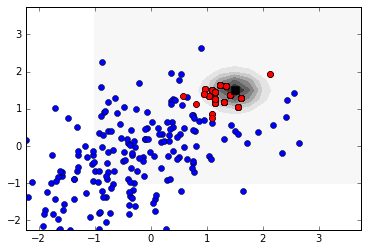

In [114]:
Ho = np.eye(2)
yo = np.array([1.5, 1.5])
Ro = 0.09*np.eye(2)
xxa = particle_filter_analysis(xxb, Ho, yo, Ro)

X = np.arange(-1., 4., 0.25)
Y = np.arange(-1., 4., 0.25)
X, Y = np.meshgrid(X, Y)
Z = gauss2D(X, Y, yo, Ro, 0.25)
plt.figure()
plt.plot(xxb[:,0], xxb[:,1], 'bo', markersize=6)
plt.plot(xxa[:,0], xxa[:,1], 'ro', markersize=6)
plt.contourf(X,Y,Z,cmap='Greys')
plt.plot(yo[0], yo[1], 'ks', markersize=8)
plt.show()